In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=92ca0b234e8dd80d2d567fe4c3ea753e96da62f075214f2a4f09f50370836b35
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col
import pyspark.sql.functions as F
from pyspark.sql.functions import count
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [ ]:
spark = SparkSession.builder.appName('Natural_Language_processing_with_Diasater_Tweets').getOrCreate()

In [ ]:
sdf_train = spark.read.csv('/content/train.csv', header = True, inferSchema = True)
sdf_train.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
pd.DataFrame(sdf_train.take(5), columns=sdf_train.columns)

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
print("Training Data Record Count:",sdf_train.count())

Training Data Record Count: 8387


In [ ]:
sdf_train.toPandas().groupby(['target']).size()

target
0.0    4095
1.0    3081
dtype: int64

Text(0.5, 1.0, 'target distribution with pie chart')

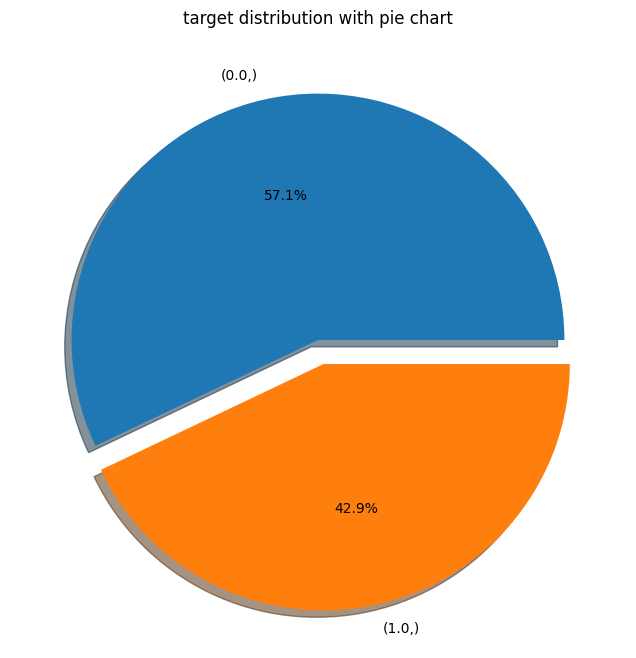

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
sdf_train.select("target").toPandas().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax,shadow=True)
ax.set_title("target distribution with pie chart")

In [ ]:
# check nan value
sdf_train.toPandas().isna().sum()

id             0
keyword      400
location    3307
text         776
target      1211
dtype: int64

In [ ]:
# drop the row when text field is nan
# using subset for targeting text fieled
print(sdf_train.dropna(subset=["text"]).toPandas().isna().sum())
sdf_train = sdf_train.dropna(subset=["text"])

id             0
keyword       61
location    2533
text           0
target       435
dtype: int64


In [ ]:
# temporaly drop the row when target is nan
# todo is seudo labelling(with clustering...)
sdf_train = sdf_train.dropna(subset=["target"])
sdf_train.toPandas().isna().sum()

id             0
keyword       61
location    2405
text           0
target         0
dtype: int64

In [ ]:
print("Training Data Record Count:",sdf_train.count())

Training Data Record Count: 7176


In [ ]:
# grouping target & keyword
# using filter for condition!
sdf_train_group_0 = sdf_train.filter((sdf_train.target == 0)).groupby("target","keyword").agg(count("keyword"))
print("Shape: ",sdf_train_group_0.count(),"," ,len(sdf_train_group_0.columns))
sdf_train_group_0.sort("count(keyword)",ascending=False).show()

Shape:  219 , 3
+------+-----------+--------------+
|target|    keyword|count(keyword)|
+------+-----------+--------------+
|     0|body%20bags|            39|
|     0|    wrecked|            36|
|     0|     deluge|            36|
|     0|       ruin|            36|
|     0|       harm|            35|
|     0|      siren|            33|
|     0|    twister|            33|
|     0| armageddon|            33|
|     0|      crush|            33|
|     0| aftershock|            32|
|     0|traumatised|            32|
|     0|   blizzard|            32|
|     0|      panic|            32|
|     0|      blaze|            32|
|     0|    sinking|            32|
|     0|  screaming|            32|
|     0|    explode|            32|
|     0|       fear|            31|
|     0|  panicking|            31|
|     0|   hellfire|            31|
+------+-----------+--------------+
only showing top 20 rows



In [ ]:
# Check the length of text field
import pyspark.sql.functions as F
train_df = sdf_train.withColumn("length_of_text", F.length("text"))
train_df.toPandas()

,id,keyword,location,text,target,length_of_text
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,38
2,5,None,None,All residents asked to 'shelter in place' are ...,1,133
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,65
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,88
...,...,...,...,...,...,...
7171,10869,None,None,Two giant cranes holding a bridge collapse int...,1,83
7172,10870,None,None,@aria_ahrary @TheTawniest The out of control w...,1,125
7173,10871,None,None,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7174,10872,None,None,Police investigating after an e-bike collided ...,1,137


In [ ]:
ml_df = sdf_train.select("id","text","target")
ml_df.show(5)

+---+--------------------+------+
| id|                text|target|
+---+--------------------+------+
|  1|Our Deeds are the...|     1|
|  4|Forest fire near ...|     1|
|  5|All residents ask...|     1|
|  6|13,000 people rec...|     1|
|  7|Just got sent thi...|     1|
+---+--------------------+------+
only showing top 5 rows



In [ ]:
ml_df = ml_df.withColumn("only_str",regexp_replace(col('text'), '\d+', ''))
ml_df.show(5)

+---+--------------------+------+--------------------+
| id|                text|target|            only_str|
+---+--------------------+------+--------------------+
|  1|Our Deeds are the...|     1|Our Deeds are the...|
|  4|Forest fire near ...|     1|Forest fire near ...|
|  5|All residents ask...|     1|All residents ask...|
|  6|13,000 people rec...|     1|, people receive ...|
|  7|Just got sent thi...|     1|Just got sent thi...|
+---+--------------------+------+--------------------+
only showing top 5 rows



In [ ]:
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(ml_df)
raw_words.show(5)

+---+--------------------+------+--------------------+--------------------+
| id|                text|target|            only_str|               words|
+---+--------------------+------+--------------------+--------------------+
|  1|Our Deeds are the...|     1|Our Deeds are the...|[our, deeds, are,...|
|  4|Forest fire near ...|     1|Forest fire near ...|[forest, fire, ne...|
|  5|All residents ask...|     1|All residents ask...|[all, residents, ...|
|  6|13,000 people rec...|     1|, people receive ...|[people, receive,...|
|  7|Just got sent thi...|     1|Just got sent thi...|[just, got, sent,...|
+---+--------------------+------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)
words_df.select("id","words","target","filtered").show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------------------------------------------------------------------------------------------------+
|id |words                                                                                                                                                    |target|filtered                                                                                            |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------------------------------------------------------------------------------------------------+
|1  |[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]                                                                       |1     |[deeds, reason, earthquake, ma

In [ ]:
cv = CountVectorizer(inputCol="filtered", outputCol="count_vectorized_features")
model = cv.fit(words_df)
countVectorizer_train = model.transform(words_df)
countVectorizer_train = countVectorizer_train.withColumn("label", col('target'))
countVectorizer_train.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-------------------------+-----+
| id|                text|target|            only_str|               words|            filtered|count_vectorized_features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-------------------------+-----+
|  1|Our Deeds are the...|     1|Our Deeds are the...|[our, deeds, are,...|[deeds, reason, e...|     (19663,[24,65,149...|    1|
|  4|Forest fire near ...|     1|Forest fire near ...|[forest, fire, ne...|[forest, fire, ne...|     (19663,[7,100,138...|    1|
|  5|All residents ask...|     1|All residents ask...|[all, residents, ...|[residents, asked...|     (19663,[159,584,9...|    1|
|  6|13,000 people rec...|     1|, people receive ...|[people, receive,...|[people, receive,...|     (19663,[11,23,159...|    1|
|  7|Just got sent thi...|     1|Just got sent thi...|[just, got, sent,...|[got, sent, photo...| 

In [ ]:
(train, testData) = countVectorizer_train.randomSplit([0.8, 0.2], seed=97435)

Machine Learning Prediction Models


Naive Bayes Classifier

In [ ]:
# Define and train the NaiveBayes model
nb = NaiveBayes(modelType="multinomial", labelCol="label", featuresCol="count_vectorized_features")
nbModel = nb.fit(train)

# Make predictions on the validation data
nb_predictions = nbModel.transform(testData)

# Evaluate the model using BinaryClassificationEvaluator
nbEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', nbEval.evaluate(nb_predictions))

# Evaluate the model's accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g" % nb_accuracy)

Test Area Under ROC 0.4302179682948281
Accuracy of NaiveBayes is = 0.803413


Logistic Regression Model

In [ ]:
# Define and train the Logistic Regression model
lr = LogisticRegression(featuresCol="count_vectorized_features", labelCol="label", maxIter=10)
lrModel = lr.fit(train)

# Make predictions on the validation data
lrPreds = lrModel.transform(testData)

# Evaluate the model using BinaryClassificationEvaluator
lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

# Evaluate the model's accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lrPreds)
print("Accuracy of Logistic Regression is = %g" % lr_accuracy)


Test Area Under ROC 0.827757828237632
Accuracy of Logistic Regression is = 0.791126


Decision Tree Classifier

In [ ]:
# Define and train the Decision Tree Classifier model
dt = DecisionTreeClassifier(featuresCol="count_vectorized_features", labelCol="label", maxDepth=3)
dtModel = dt.fit(train)

# Make predictions on the validation data
dtPreds = dtModel.transform(testData)

# Evaluate the model using BinaryClassificationEvaluator
dtEval = BinaryClassificationEvaluator()
print("Test Area Under ROC: ", dtEval.evaluate(dtPreds))

# Evaluate the model's accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dtPreds)
print("Accuracy of Decision Trees is = %g" % dt_accuracy)

Test Area Under ROC:  0.6226871332447346
Accuracy of Decision Trees is = 0.643003


Random Forest Classifier

In [ ]:
# Define and train the Random Forest Classifier model
rf = RandomForestClassifier(featuresCol="count_vectorized_features", labelCol="label")
rfModel = rf.fit(train)

# Make predictions on the validation data
rfPreds = rfModel.transform(testData)

# Evaluate the model using BinaryClassificationEvaluator
rfEval = BinaryClassificationEvaluator()
print("Test Area Under ROC: ", rfEval.evaluate(rfPreds))

# Evaluate the model's accuracy using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rfPreds)
print("Accuracy of Random Forests is = %g" % rf_accuracy)

Test Area Under ROC:  0.7399812266999738
Accuracy of Random Forests is = 0.605461


ML Pipeline

In [ ]:
# Logistic Regression Pipeline
lr = LogisticRegression(featuresCol='count_vectorized_features', labelCol='label')
lr_pipeline = Pipeline(stages=[lr])

# Decision Tree Pipeline
dt = DecisionTreeClassifier(featuresCol='count_vectorized_features', labelCol='label')
dt_pipeline = Pipeline(stages=[dt])

# Random Forest Pipeline
rf = RandomForestClassifier(featuresCol='count_vectorized_features', labelCol='label')
rf_pipeline = Pipeline(stages=[rf])

# Naive Bayes Pipeline
nb = NaiveBayes(featuresCol='count_vectorized_features', labelCol='label')
nb_pipeline = Pipeline(stages=[nb])

In [ ]:
# Hyperparameter grid for each model
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20]) \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()


paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 7]) \
    .addGrid(dt.minInstancesPerNode, [1, 3, 5]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2']) \
    .build()

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 1.0]) \
    .build()


In [ ]:
# Cross-validation setup
crossval_lr = CrossValidator(estimator=lr_pipeline, estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(
                                 labelCol='label', predictionCol='prediction', metricName='accuracy'),
                             numFolds=5)

crossval_dt = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=paramGrid_dt,
                             evaluator=MulticlassClassificationEvaluator(
                                 labelCol='label', predictionCol='prediction', metricName='accuracy'),
                             numFolds=5)

crossval_rf = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=paramGrid_rf,
                             evaluator=MulticlassClassificationEvaluator(
                                 labelCol='label', predictionCol='prediction', metricName='accuracy'),
                             numFolds=5)

crossval_nb = CrossValidator(estimator=nb_pipeline, estimatorParamMaps=paramGrid_nb,
                              evaluator=MulticlassClassificationEvaluator(
                                  labelCol='label', predictionCol='prediction', metricName='accuracy'),
                              numFolds=5)


In [ ]:
# Fit the models
cvModel_lr = crossval_lr.fit(train)
cvModel_dt = crossval_dt.fit(train)
cvModel_rf = crossval_rf.fit(train)
cvModel_nb = crossval_nb.fit(train)

best_model_lr = cvModel_lr.bestModel
best_model_dt = cvModel_dt.bestModel
best_model_rf = cvModel_rf.bestModel
best_model_nb = cvModel_nb.bestModel

In [ ]:
# Evaluate the Logistic Regression model on test data
predictions_lr = best_model_lr.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
print(f"Test Accuracy for Logistic Regression: {accuracy_lr:.2f}")

# Evaluate the Decision Tree model on test data
predictions_dt = best_model_dt.transform(testData)
accuracy_dt = evaluator.evaluate(predictions_dt)
print(f"Test Accuracy for Decision Tree: {accuracy_dt:.2f}")

# Evaluate the Random Forest model on test data
predictions_rf = best_model_rf.transform(testData)
accuracy_rf = evaluator.evaluate(predictions_rf)
print(f"Test Accuracy for Random Forest: {accuracy_rf:.2f}")

# Evaluate the Gaussian NB Tree model on test data
predictions_nb = best_model_nb.transform(testData)
accuracy_nb = evaluator.evaluate(predictions_nb)
print(f"Test Accuracy for Naive Bayes: {accuracy_nb:.2f}")

Test Accuracy for Logistic Regression: 0.79
Test Accuracy for Decision Tree: 0.65
Test Accuracy for Random Forest: 0.66
Test Accuracy for Naive Bayes: 0.80


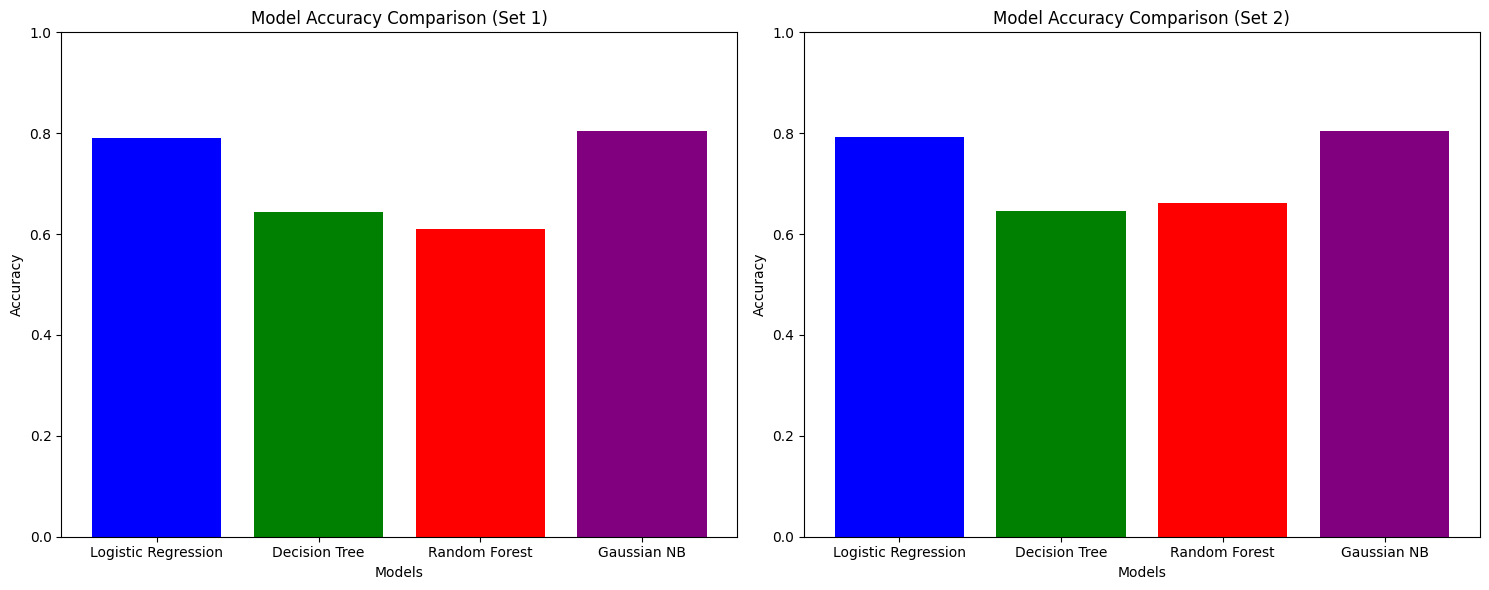

In [ ]:
import matplotlib.pyplot as plt

# Define the model names and their corresponding accuracies for the first set of results
model_names_1 = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gaussian NB']
accuracies_1 = [lr_accuracy, dt_accuracy, rf_accuracy, nb_accuracy]

# Define the model names and their corresponding accuracies for the second set of results
model_names_2 = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gaussian NB']
accuracies_2 = [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_nb]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first set of results
axes[0].bar(model_names_1, accuracies_1, color=['blue', 'green', 'red', 'purple'])
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison (Set 1)')
axes[0].set_ylim(0, 1)

# Plot the second set of results
axes[1].bar(model_names_2, accuracies_2, color=['blue', 'green', 'red', 'purple'])
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy Comparison (Set 2)')
axes[1].set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()